In [1]:
import sys
sys.path.append('../src/')

from benchmark.tools import *
from benchmark.models import Detector
from benchmark.utils import TsvHandle, run_detection, tf_to_image_faces

import wider_dataset

In [2]:
from yoloface import get_outputs_names, post_process

In [3]:
model_cfg = '../src/yoloface/cfg/yolov3-face.cfg'
model_weights = '../src/yoloface/model-weights/yolov3-wider_16000.weights'

In [4]:
net = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [5]:
IMG_WIDTH = 416
IMG_HEIGHT = 416

CONF_THRESHOLD = 0.5
NMS_THRESHOLD = 0.4

In [6]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])

data = validation.take(1)

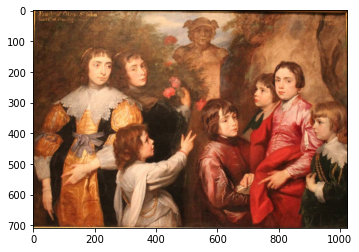

In [7]:
for sample in data:
    image_faces = tf_to_image_faces(sample)
    img = image_faces.img
    blob = cv2.dnn.blobFromImage(img, 1 / 255, (IMG_WIDTH, IMG_HEIGHT),
                                     [0, 0, 0], 1, crop=False)
    net.setInput(blob)
    outs = net.forward(get_outputs_names(net))
    faces = post_process(img, outs, CONF_THRESHOLD, NMS_THRESHOLD)
    plt.imshow(img)
    plt.show()